In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [6]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [11]:
root = '../Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [12]:
class_names

['CAT', 'DOG']

In [13]:
len(train_data)

18743

In [14]:
len(test_data)

6251

In [15]:
for images, labels in train_loader:
    break

In [16]:
images.shape

torch.Size([10, 3, 224, 224])

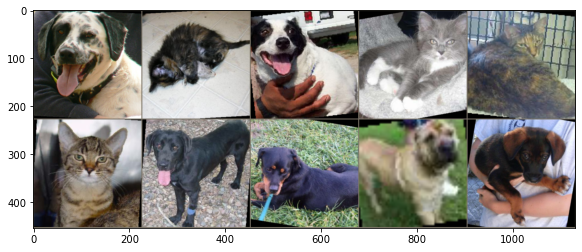

In [18]:
im = make_grid(images, nrow=5)

inv_normalize = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

im_inv = inv_normalize(im)
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [24]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54 * 54 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54 * 54 * 16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [25]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [26]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [27]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [29]:
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b +=1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            print(f'Epoch {i} LOSS: {loss.item()}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            y_val = CNNmodel(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Total Time: {total_time / 60} minutes')

Epoch 0 LOSS: 0.5539386868476868
Epoch 0 LOSS: 0.5595372915267944
Epoch 0 LOSS: 0.3456532061100006
Epoch 0 LOSS: 0.8342011570930481
Epoch 1 LOSS: 0.5544875860214233
Epoch 1 LOSS: 0.6328862905502319
Epoch 1 LOSS: 0.7801064252853394
Epoch 1 LOSS: 0.25901269912719727
Epoch 2 LOSS: 0.3217480480670929
Epoch 2 LOSS: 0.43756628036499023
Epoch 2 LOSS: 0.7172383069992065
Epoch 2 LOSS: 0.48630061745643616
Total Time: 10.2954873641332 minutes


In [30]:
torch.save(CNNmodel.state_dict(), 'my3epochmodel.pt')

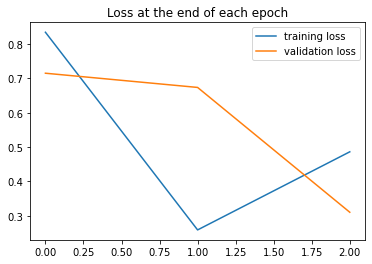

In [32]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend()

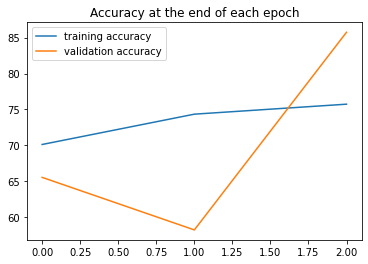

In [33]:
plt.plot([t / 80 for t in train_correct], label='training accuracy')
plt.plot([t / 30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [35]:
test_correct[-1].item() * 100 / 3000

85.73333333333333

In [36]:
AlexNetModel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/saint1729/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [37]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [39]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [41]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024, 2),
                                        nn.LogSoftmax(dim=1))

In [42]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [43]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

In [45]:
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b +=1
        
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{10 * b:6} / 8000] loss: {loss.item():10.8f} accuracy: {trn_corr.item() * 100 / (10 * b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            y_val = AlexNetModel(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Total Time: {total_time / 60} minutes')

/Users/saint1729/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/Users/saint1729/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/Users/saint1729/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/Users/saint1729/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/Users/saint1729/opt/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping

epoch:  0 batch:  200 [  2000 / 8000] loss: 1.18503404 accuracy:  88.250%
epoch:  0 batch:  400 [  4000 / 8000] loss: 0.16676216 accuracy:  89.925%
epoch:  0 batch:  600 [  6000 / 8000] loss: 0.79356861 accuracy:  90.950%
epoch:  0 batch:  800 [  8000 / 8000] loss: 0.22268745 accuracy:  91.812%
Total Time: 5.436292449633281 minutes


In [63]:
print(test_correct[-1].item() * 100 / 3000)

94.33333333333333


1173
DOG
CAT


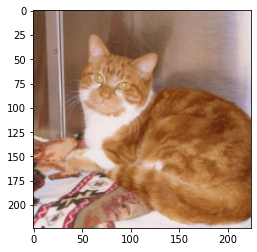

In [77]:
found = False

while not found:
    image_index = np.random.randint(1, 5000)

    CNNmodel.eval()

    with torch.no_grad():
        pred1 = CNNmodel(test_data[image_index][0].view(1, 3, 224, 224)).argmax()

    AlexNetModel.eval()

    with torch.no_grad():
        pred2 = AlexNetModel(test_data[image_index][0].view(1, 3, 224, 224)).argmax()

    if pred1.item() != pred2.item():
        im = inv_normalize(test_data[image_index][0])
        plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
        print(image_index)
        print(class_names[pred1.item()])
        print(class_names[pred2.item()])
        found = True
